In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
stock_price = pd.read_csv("../dataset/stock_price_data/Pfizer_data.csv")

In [3]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-01,35.930000,36.020000,35.430000,35.430000,34.060383,20885200
1,2019-10-02,35.259998,35.270000,34.660000,34.700001,33.358604,21307400
2,2019-10-03,34.709999,35.470001,34.599998,35.450001,34.079609,20945100
3,2019-10-04,35.490002,35.980000,35.450001,35.930000,34.541054,17139800
4,2019-10-07,35.820000,36.259998,35.799999,35.830002,34.444920,11156900


In [4]:
pfizer_close = stock_price['Close']
n = 7
moving_avg = [sum(pfizer_close[i-n:i])/n for i in range(n, len(pfizer_close))]
moving_stdev = (pfizer_close[n:] - moving_avg)**2

m = 3
moving_stdev_smooth = [sum(moving_stdev[i-m:i])/m for i in range(m,len(moving_stdev))]

dates = pd.to_datetime(stock_price["Date"], format = '%Y-%m-%d')
dates.head()


0   2019-10-01
1   2019-10-02
2   2019-10-03
3   2019-10-04
4   2019-10-07
Name: Date, dtype: datetime64[ns]

/Users/suraj/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


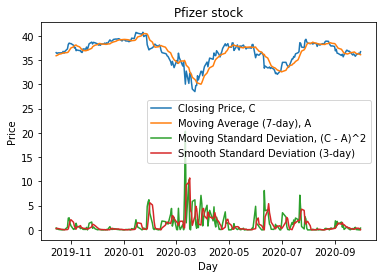

In [5]:
plt.plot(dates[n+m:], pfizer_close[n+m:], label="Closing Price, C")
plt.plot(dates[n+m:], moving_avg[m:], label=f"Moving Average ({n}-day), A")
plt.plot(dates[n+m:], moving_stdev[m:], label="Moving Standard Deviation, (C - A)^2")
plt.plot(dates[n+m:], moving_stdev_smooth, label=f"Smooth Standard Deviation ({m}-day)")
plt.title("Pfizer stock")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Price")
plt.rcParams["figure.figsize"]=(15,5) # (width, height)
plt.show()

In [9]:
labels = [1 if i > 2 else 0 for i in moving_stdev_smooth]
print(labels)
len(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


243

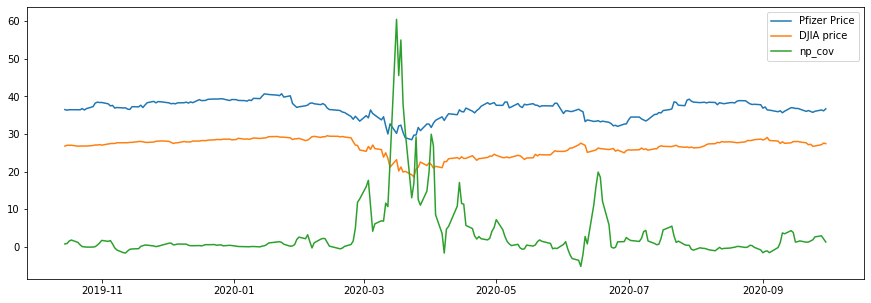

In [7]:
#alternative for labeling
# djia = pd.read_csv("../dataset/stock_price_data/DJIA_data.csv")
# djia_data = djia['Close']
# np_cov = np.array([np.cov(pfizer_close[i-n:i], djia_data[i-n:i])[0,1]/n for i in range(n, len(pfizer_close))])
# np_cov[:10]
# djia = pd.read_csv("../dataset/stock_price_data/DJIA_data.csv")
# djia_data = djia['Close']
# np_cov = np.array([np.cov(pfizer_close[i-n:i], djia_data[i-n:i])[0,1]/n for i in range(n, len(pfizer_close))])
# np_cov[:10]
# plt.plot(dates[n+m:], pfizer_close[n+m:], label="Pfizer Price")
# plt.plot(dates[n+m:], djia_data[m+n-1:]/1000, label="DJIA price")
# plt.plot(dates[n+m:], np_cov[2:-1]/10, label='np_cov')
# plt.legend()
# plt.show()